<a href="https://colab.research.google.com/github/Shahanas2003/gen_ai/blob/main/High_Resolution_Image_Enhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install torch Pillow numpy scikit-image
!pip install git+https://github.com/sberbank-ai/Real-ESRGAN.git


  Cloning https://github.com/sberbank-ai/Real-ESRGAN.git to /tmp/pip-req-build-jxglqrwz
  Running command git clone --filter=blob:none --quiet https://github.com/sberbank-ai/Real-ESRGAN.git /tmp/pip-req-build-jxglqrwz
  Resolved https://github.com/sberbank-ai/Real-ESRGAN.git to commit 362a0316878f41dbdfbb23657b450c3353de5acf
  Preparing metadata (setup.py) ... done


In [35]:
!pip install torch torchvision


In [43]:
!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
!tar -xvzf BSDS300-images.tgz


--2025-10-26 13:32:56--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
Resolving www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)... 128.32.244.190
Connecting to www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22211847 (21M) [application/x-tar]
Saving to: ‘BSDS300-images.tgz.1’

BSDS300-images.tgz. 100%[===================>]  21.18M  85.9MB/s    in 0.2s    

2025-10-26 13:32:56 (85.9 MB/s) - ‘BSDS300-images.tgz.1’ saved [22211847/22211847]

BSDS300/images/
BSDS300/images/train/
BSDS300/images/train/159029.jpg
BSDS300/images/train/20008.jpg
BSDS300/images/train/155060.jpg
BSDS300/images/train/286092.jpg
BSDS300/images/train/100075.jpg
BSDS300/images/train/61060.jpg
BSDS300/images/train/46076.jpg
BSDS300/images/train/301007.jpg
BSDS300/images/train/26031.jpg
BSDS300/images/train/232038.jpg
BSDS300/images/train/45077.jpg
BSDS300/images/train/365025.jpg
BSDS300/image

Epoch 0/5, Step 0, G Loss: 0.25913, D Loss: 1.39606
Epoch 0/5, Step 10, G Loss: 0.03758, D Loss: 0.94326
Epoch 0/5, Step 20, G Loss: 0.03295, D Loss: 0.58659
Epoch 0/5, Step 30, G Loss: 0.02641, D Loss: 0.35660
Epoch 0/5, Step 40, G Loss: 0.03037, D Loss: 0.27312
Epoch 1/5, Step 0, G Loss: 0.01823, D Loss: 0.19597
Epoch 1/5, Step 10, G Loss: 0.02267, D Loss: 0.12241
Epoch 1/5, Step 20, G Loss: 0.02548, D Loss: 0.09108
Epoch 1/5, Step 30, G Loss: 0.01697, D Loss: 0.07253
Epoch 1/5, Step 40, G Loss: 0.02377, D Loss: 0.06890
Epoch 2/5, Step 0, G Loss: 0.02093, D Loss: 0.15576
Epoch 2/5, Step 10, G Loss: 0.02158, D Loss: 0.06359
Epoch 2/5, Step 20, G Loss: 0.01185, D Loss: 0.05882
Epoch 2/5, Step 30, G Loss: 0.01468, D Loss: 0.05522
Epoch 2/5, Step 40, G Loss: 0.01017, D Loss: 0.04209
Epoch 3/5, Step 0, G Loss: 0.01154, D Loss: 0.21792
Epoch 3/5, Step 10, G Loss: 0.01283, D Loss: 0.11439
Epoch 3/5, Step 20, G Loss: 0.00855, D Loss: 0.10415
Epoch 3/5, Step 30, G Loss: 0.01032, D Loss: 0.044

Average PSNR: 28.40


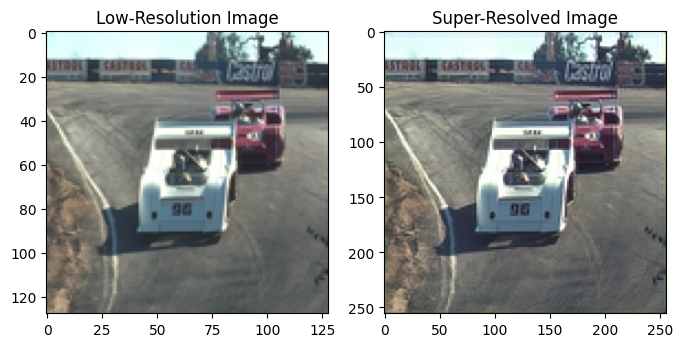

In [61]:
# Install requirements in Colab (uncomment if needed)
# !pip install torch torchvision pillow numpy matplotlib scikit-image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
from skimage.metrics import peak_signal_noise_ratio as psnr
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# -------- Dataset --------

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Preprocess: downscale to low-res, then upsample (model learns to upsample)
hr_transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
lr_transform = transforms.Compose([transforms.Resize((128,128), interpolation=Image.BICUBIC), transforms.ToTensor()])

class SRDataset(Dataset):
    def __init__(self, root_dir):
        self.hr_dir = root_dir
        self.image_files = os.listdir(root_dir)
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        img_name = os.path.join(self.hr_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")
        hr = hr_transform(image)
        lr = lr_transform(image)
        return lr, hr

dataset = SRDataset(root_dir="BSDS300/images/train")
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# -------- Model --------

class RRDB(nn.Module):
    def __init__(self, in_channels):
        super(RRDB, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.conv3(out)
        return x + out

class Generator(nn.Module):
    def __init__(self, in_channels=3, num_rrdb=8, upsample_blocks=1):
        super(Generator, self).__init__()
        self.initial_conv = nn.Conv2d(in_channels, 64, 3, 1, 1)
        self.rrdb_blocks = nn.Sequential(*[RRDB(64) for _ in range(num_rrdb)])
        # Upsample until we double H,W each time; for 128->256 use 1 block, for 128->512 use 2
        upsample_layers = []
        for _ in range(upsample_blocks):
            upsample_layers += [
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.PixelShuffle(2),  # doubles H,W
                nn.LeakyReLU(0.2, inplace=True)
            ]
        self.upsample = nn.Sequential(*upsample_layers)
        self.final_conv = nn.Conv2d(64, in_channels, 3, 1, 1)
    def forward(self, x):
        fea = self.initial_conv(x)
        out = self.rrdb_blocks(fea)
        out = self.upsample(out)
        out = self.final_conv(out)
        return out

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, 2, 1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(in_channels, 64, False),
            *block(64, 128),
            *block(128, 256),
            *block(256, 512),
            nn.Conv2d(512, 1, 3, 1, 1)
        )
    def forward(self, img):
        return self.model(img)

# -------- Losses --------

class ContentLoss(nn.Module):
    def __init__(self):
        super(ContentLoss, self).__init__()
    def forward(self, sr, hr):
        return F.mse_loss(sr, hr)

class PerceptualLoss(nn.Module):
    def __init__(self, vgg_model):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg_model.features[:36]
        self.vgg.eval()
    def forward(self, sr, hr):
        sr_features = self.vgg(sr)
        hr_features = self.vgg(hr)
        return F.mse_loss(sr_features, hr_features)

# -------- Training --------

def train(generator, discriminator, dataloader, num_epochs, optimizer_G, optimizer_D, criterion_content, criterion_perceptual, device):
    generator.to(device)
    discriminator.to(device)
    for epoch in range(num_epochs):
        for i, (lr, hr) in enumerate(dataloader):
            lr, hr = lr.to(device), hr.to(device)

            # Generate super-resolved image
            sr_image = generator(lr)

            # Train Generator
            optimizer_G.zero_grad()
            content_loss = criterion_content(sr_image, hr)
            perceptual_loss = criterion_perceptual(sr_image, hr)
            g_loss = content_loss + 0.1 * perceptual_loss
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_output = discriminator(hr)
            fake_output = discriminator(sr_image.detach())
            d_loss = F.binary_cross_entropy_with_logits(real_output, torch.ones_like(real_output)) + \
                     F.binary_cross_entropy_with_logits(fake_output, torch.zeros_like(fake_output))
            d_loss.backward()
            optimizer_D.step()

            if i % 10 == 0:
                print(f"Epoch {epoch}/{num_epochs}, Step {i}, G Loss: {g_loss.item():.5f}, D Loss: {d_loss.item():.5f}")

def evaluate_psnr(generator, dataloader, device):
    generator.eval()
    total_psnr, count = 0, 0
    with torch.no_grad():
        for lr, hr in dataloader:
            lr, hr = lr.to(device), hr.to(device)
            sr = generator(lr)
            for i in range(hr.size(0)):
                sr_img = sr[i].cpu().numpy().transpose(1,2,0)
                hr_img = hr[i].cpu().numpy().transpose(1,2,0)
                sr_img = (sr_img * 255).clip(0,255).astype('uint8')
                hr_img = (hr_img * 255).clip(0,255).astype('uint8')
                total_psnr += psnr(hr_img, sr_img, data_range=255)
                count += 1
    print(f"Average PSNR: {total_psnr/(count or 1):.2f}")

# -------- Main --------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(upsample_blocks=1)  # 1 = x2 upscaling, 2 = x4 upscaling
discriminator = Discriminator()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

from torchvision.models import VGG19_Weights
vgg = models.vgg19(weights=VGG19_Weights.DEFAULT).to(device)
criterion_content = ContentLoss()
criterion_perceptual = PerceptualLoss(vgg)

train(generator, discriminator, dataloader, num_epochs=5, optimizer_G=optimizer_G, optimizer_D=optimizer_D,
      criterion_content=criterion_content, criterion_perceptual=criterion_perceptual, device=device)

evaluate_psnr(generator, dataloader, device)

# -------- Test and Visualize Output --------

# Example test image from your dataset or any image you want
test_image = Image.open("BSDS300/images/test/21077.jpg").convert("RGB")
hr_test = hr_transform(test_image).unsqueeze(0).to(device)
lr_test = lr_transform(test_image).unsqueeze(0).to(device)

generator.eval()
with torch.no_grad():
    sr_image = generator(lr_test)
save_image(sr_image, "sr_image.png")
save_image(lr_test, "lr_image.png")

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.title("Low-Resolution Image")
plt.imshow(np.transpose(lr_test.squeeze().cpu().numpy(), (1,2,0)))
plt.subplot(1,2,2)
plt.title("Super-Resolved Image")
plt.imshow(np.transpose(sr_image.squeeze().cpu().numpy(), (1,2,0)))
plt.show()


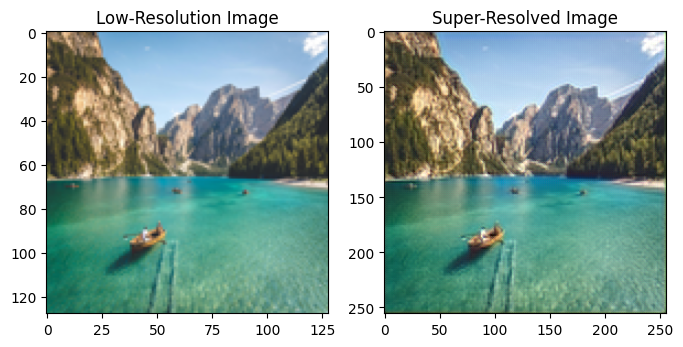

In [64]:
# Example test image from your dataset or any image you want
test_image = Image.open("/content/low_res_image.jpg").convert("RGB")
hr_test = hr_transform(test_image).unsqueeze(0).to(device)
lr_test = lr_transform(test_image).unsqueeze(0).to(device)

generator.eval()
with torch.no_grad():
    sr_image = generator(lr_test)
save_image(sr_image, "sr_image.png")
save_image(lr_test, "lr_image.png")

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.title("Low-Resolution Image")
plt.imshow(np.transpose(lr_test.squeeze().cpu().numpy(), (1,2,0)))
plt.subplot(1,2,2)
plt.title("Super-Resolved Image")
plt.imshow(np.transpose(sr_image.squeeze().cpu().numpy(), (1,2,0)))
plt.show()

In [59]:
from PIL import Image
import requests
from io import BytesIO

image_url = "https://images.unsplash.com/photo-1501785888041-af3ef285b470"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content)).convert("RGB")

low_res = img.resize((img.width // 2, img.height // 2), Image.BICUBIC)
low_res.save("low_res_image1.jpg")

In [65]:
# Install requirements in Colab (uncomment below if needed)
# !pip install torch torchvision pillow numpy matplotlib scikit-image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# -------- DATA LOADING (Low-Res/High-Res pairs) --------

class SRDataset(Dataset):
    def __init__(self, root_dir):
        self.hr_dir = root_dir
        self.image_files = os.listdir(root_dir)
        self.hr_transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
        self.lr_transform = transforms.Compose([transforms.Resize((128,128), interpolation=Image.BICUBIC), transforms.ToTensor()])
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        img_name = os.path.join(self.hr_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")
        hr = self.hr_transform(image)
        lr = self.lr_transform(image)
        return lr, hr

dataset = SRDataset(root_dir="BSDS300/images/train")
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# -------- ESRGAN MODULES (Generator/Discriminator) --------

class RRDB(nn.Module):
    def __init__(self, in_channels):
        super(RRDB, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.conv3(out)
        return x + out

class Generator(nn.Module):
    def __init__(self, in_channels=3, num_rrdb=16, upsample_blocks=1):
        super(Generator, self).__init__()
        self.initial_conv = nn.Conv2d(in_channels, 64, 3, 1, 1)
        self.rrdb_blocks = nn.Sequential(*[RRDB(64) for _ in range(num_rrdb)])
        upsample_layers = []
        for _ in range(upsample_blocks):  # 1 block = x2, 2 = x4 super-resolution
            upsample_layers += [
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.PixelShuffle(2),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        self.upsample = nn.Sequential(*upsample_layers)
        self.final_conv = nn.Conv2d(64, in_channels, 3, 1, 1)
    def forward(self, x):
        fea = self.initial_conv(x)
        out = self.rrdb_blocks(fea)
        out = self.upsample(out)
        out = self.final_conv(out)
        return out

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, 2, 1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(in_channels, 64, False),
            *block(64, 128),
            *block(128, 256),
            *block(256, 512),
            nn.Conv2d(512, 1, 3, 1, 1)
        )
    def forward(self, img):
        return self.model(img)

# -------- LOSS FUNCTIONS --------

class ContentLoss(nn.Module):
    def __init__(self):
        super(ContentLoss, self).__init__()
    def forward(self, sr, hr):
        return F.l1_loss(sr, hr)  # L1 often sharper than MSE (use MSE if preferred)

class PerceptualLoss(nn.Module):
    def __init__(self, vgg_model):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg_model.features[:36]
        self.vgg.eval()
    def forward(self, sr, hr):
        sr_features = self.vgg(sr)
        hr_features = self.vgg(hr)
        return F.mse_loss(sr_features, hr_features)

# -------- TRAINING LOOP --------

def train(generator, discriminator, dataloader, num_epochs, optimizer_G, optimizer_D, criterion_content, criterion_perceptual, device):
    generator.to(device)
    discriminator.to(device)
    for epoch in range(num_epochs):
        for i, (lr, hr) in enumerate(dataloader):
            lr, hr = lr.to(device), hr.to(device)
            # Generate
            sr_image = generator(lr)

            # Generator
            optimizer_G.zero_grad()
            content_loss = criterion_content(sr_image, hr)
            perceptual_loss = criterion_perceptual(sr_image, hr)
            # (Basic adversarial loss can be added for even sharper results)
            g_loss = content_loss + 0.1 * perceptual_loss
            g_loss.backward()
            optimizer_G.step()

            # Discriminator
            optimizer_D.zero_grad()
            real_output = discriminator(hr)
            fake_output = discriminator(sr_image.detach())
            d_loss = F.binary_cross_entropy_with_logits(real_output, torch.ones_like(real_output)) + \
                     F.binary_cross_entropy_with_logits(fake_output, torch.zeros_like(fake_output))
            d_loss.backward()
            optimizer_D.step()

            if i % 20 == 0:
                print(f"Epoch {epoch}/{num_epochs}, Step {i}, G Loss: {g_loss.item():.5f}, D Loss: {d_loss.item():.5f}")

# -------- EVALUATION --------

def evaluate_psnr(generator, dataloader, device):
    generator.eval()
    total_psnr, count = 0, 0
    with torch.no_grad():
        for lr, hr in dataloader:
            lr, hr = lr.to(device), hr.to(device)
            sr = generator(lr)
            for i in range(hr.size(0)):
                sr_img = sr[i].cpu().numpy().transpose(1,2,0)
                hr_img = hr[i].cpu().numpy().transpose(1,2,0)
                sr_img = (sr_img * 255).clip(0,255).astype('uint8')
                hr_img = (hr_img * 255).clip(0,255).astype('uint8')
                total_psnr += psnr(hr_img, sr_img, data_range=255)
                count += 1
    print(f"Average PSNR: {total_psnr/(count or 1):.2f}")

# -------- RUN TRAINING/TESTING --------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(num_rrdb=16, upsample_blocks=1)  # upsamples x2, increase upsample_blocks=2 for x4
discriminator = Discriminator()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

from torchvision.models import VGG19_Weights
vgg = models.vgg19(weights=VGG19_Weights.DEFAULT).to(device)
criterion_content = ContentLoss()
criterion_perceptual = PerceptualLoss(vgg)

# Train for more epochs and use more data for best results!
train(generator, discriminator, dataloader, num_epochs=10, optimizer_G=optimizer_G, optimizer_D=optimizer_D,
      criterion_content=criterion_content, criterion_perceptual=criterion_perceptual, device=device)

evaluate_psnr(generator, dataloader, device)




Epoch 0/10, Step 0, G Loss: 0.45837, D Loss: 1.41133
Epoch 0/10, Step 20, G Loss: 0.09048, D Loss: 0.89526
Epoch 1/10, Step 0, G Loss: 0.09708, D Loss: 0.75157
Epoch 1/10, Step 20, G Loss: 0.07656, D Loss: 0.23288
Epoch 2/10, Step 0, G Loss: 0.07264, D Loss: 0.21110
Epoch 2/10, Step 20, G Loss: 0.05643, D Loss: 0.11169
Epoch 3/10, Step 0, G Loss: 0.06002, D Loss: 0.16061
Epoch 3/10, Step 20, G Loss: 0.05450, D Loss: 0.04939
Epoch 4/10, Step 0, G Loss: 0.04706, D Loss: 0.06455
Epoch 4/10, Step 20, G Loss: 0.04415, D Loss: 0.02987
Epoch 5/10, Step 0, G Loss: 0.04490, D Loss: 0.03986
Epoch 5/10, Step 20, G Loss: 0.04133, D Loss: 0.02861
Epoch 6/10, Step 0, G Loss: 0.03811, D Loss: 0.04170
Epoch 6/10, Step 20, G Loss: 0.03692, D Loss: 0.04296
Epoch 7/10, Step 0, G Loss: 0.03800, D Loss: 0.04474
Epoch 7/10, Step 20, G Loss: 0.03718, D Loss: 0.02516
Epoch 8/10, Step 0, G Loss: 0.03634, D Loss: 0.01726
Epoch 8/10, Step 20, G Loss: 0.03592, D Loss: 0.02744
Epoch 9/10, Step 0, G Loss: 0.03162, 

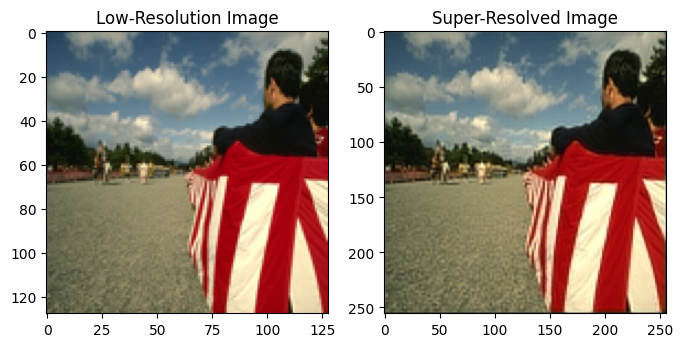

In [69]:
# -------- TEST AND VISUALIZE OUTPUT --------

test_image = Image.open("BSDS300/images/test/145086.jpg").convert("RGB")
hr_transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
lr_transform = transforms.Compose([transforms.Resize((128,128), interpolation=Image.BICUBIC), transforms.ToTensor()])
hr_test = hr_transform(test_image).unsqueeze(0).to(device)
lr_test = lr_transform(test_image).unsqueeze(0).to(device)

generator.eval()
with torch.no_grad():
    sr_image = generator(lr_test)
save_image(sr_image, "sr_image.png")
save_image(lr_test, "lr_image.png")

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.title("Low-Resolution Image")
plt.imshow(np.transpose(lr_test.squeeze().cpu().numpy(), (1,2,0)))
plt.subplot(1,2,2)
plt.title("Super-Resolved Image")
plt.imshow(np.transpose(sr_image.squeeze().cpu().numpy(), (1,2,0)))
plt.show()